# Recommendation levels stackplot

Author: Tristan Deleu

Daily distribution of recommendation levels, broken down by SEIR state.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import pickle

In [2]:
def seir_matrix(names, data):
    """The SEIR states for each human per day.

    Parameters
    ----------
    names : list of strings
        The list of the human names. This ensures the same order is used
        for SEIR states and recommendation levels.

    data : dict
        A dictionary with humans as keys and lists of SEIR states as values.

    Returns
    -------
    seir : np.ndarray instance
        An array of size (num_humans, num_days) of integers, with
        the mapping {S: 0, E: 1, I: 2, R: 3, N/A: -1}.
    """
    seir2int = {'S': 0, 'E': 1, 'I': 2, 'R': 3, 'N/A': -1}
    num_days = len(data[names[0]])
    states = np.zeros((len(names), num_days), dtype=np.int_)
    
    for i, name in enumerate(names):
        states[i] = np.asarray([seir2int[state] for state in data[name]])

    return states

In [3]:
def rec_level_matrix(names, data):
    """The recommendation levels for each human per day.
    
    Parameters
    ----------
    names : list of strings
        The list of the human names. This ensures the same order is used
        for SEIR states and recommendation levels.

    data : dict
        A dictionary with humans as keys and lists of recommendation
        levels as values.

    Returns
    -------
    rec_levels : np.ndarray instance
        An array of size (num_humans, num_days) of integers corresponding
        to the recommendation levels.
    """
    num_days = len(data[names[0]])
    rec_levels = np.zeros((len(names), num_days), dtype=np.int_)
    
    for i, name in enumerate(names):
        rec_levels[i] = np.asarray(data[name])
    return rec_levels

In [4]:
def proportion_rec_levels(rec_levels, seir):
    """Proportion of recommendation levels, broken down by SEIR state.

    Parameters
    ----------
    rec_levels : np.ndarray instance
        An array of size (num_humans, num_days) containing the
        recommendation levels.

    seir : np.ndarray instance
        An array of size (num_humans, num_days) containing the SEIR states.

    Returns
    -------
    proportions : np.ndarray instance
        Array of size (4, 4, num_days) containing the proportion of the
        population in recommendation level i with SEIR state j for each day.
    """
    proportions = np.zeros((4, 4, rec_levels.shape[1]), dtype=np.float_)
    
    for i in range(4):
        for j in range(4):
            proportions[i, j] = np.mean(np.logical_and(rec_levels == i, seir == j), axis=0)

    return proportions

In [5]:
def get_proportion_rec_levels_from_logs(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f)

    if 'humans_state' not in data:
        raise KeyError()

    intervention_day = data['intervention_day']
    names = sorted(data['humans_state'].keys())
    
    seir = seir_matrix(names, data['humans_state'])
    rec_levels = rec_level_matrix(names, data['humans_rec_level'])
    
    return proportion_rec_levels(rec_levels, seir), intervention_day

In [6]:
colors = ['#388E3C', '#4CAF50', '#81C784', '#C8E6C9', # Green
          '#FDD835', '#FFEB3B', '#FFF176', '#FFF9C4', # Yellow
          '#FB8C00', '#FF9800', '#FFB74D', '#FFE0B2', # Orange
          '#E53935', '#F44336', '#E57373', '#FFCDD2'] # Red

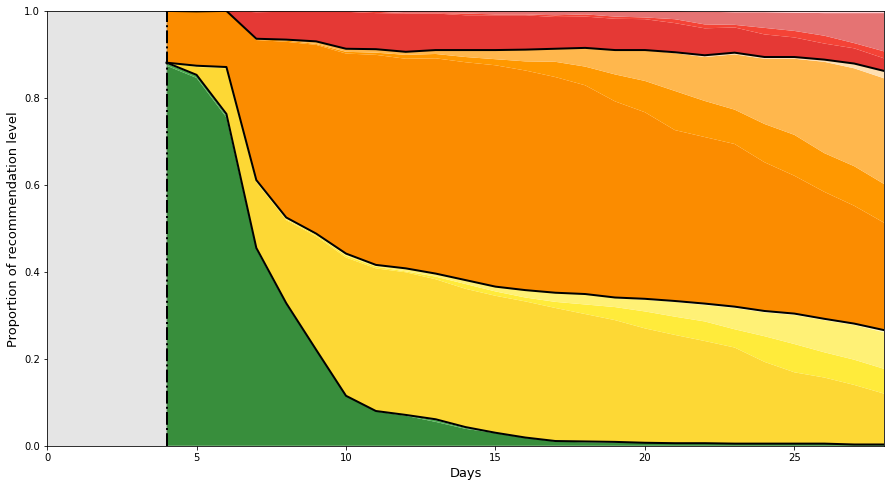

In [7]:
filename = '../2020-05-31/heuristic/sim_v2_people-1000_days-30_init-0.002_seed-1005_20200531-095542/tracker_data_n_1000_seed_1005_20200531-104110_.pkl'
proportions, intervention_day = get_proportion_rec_levels_from_logs(filename)

plt.figure(figsize=(15, 8))
ax = plt.subplot(1, 1, 1)
num_days = proportions.shape[-1]

ax.stackplot(np.arange(intervention_day - 1, num_days),
             proportions[..., intervention_day - 1:].reshape((16, -1)),
             colors=colors)

# Display lines between each recommendation level groups
levels = np.cumsum(proportions.sum(1), axis=0)
for level in levels[:-1]:
    ax.plot(np.arange(intervention_day - 1, num_days),
            level[..., intervention_day - 1:], c='k', lw=2)

# Display days pre-interventions (gray area)
ax.axvspan(0, intervention_day - 1, color='gray', alpha=0.2)
ax.axvline(intervention_day - 1, lw=2, c='k', ls='-.')

ax.set_xlabel('Days', fontsize=13)
ax.set_ylabel('Proportion of recommendation level', fontsize=13)
ax.margins(0, 0)

plt.show()